## Clustering Mobile Phone Shops using Foursquare API and Machine Learning

### Adam Siemiątkowski
Applied Data Science Capstone Project

### 1. Introduction
#### 1.1 Background
Selection of a location for a Point Of Sale is a key decision for any retail or service business. The launch of a new POS requires usually significant resources in form of money and time spent on preparation of the location. Once this money spent it becomes sunk cost.
#### 1.2 Problem
The purpose of this report is to verify whether clustering of existing Mobile Phone Shops (MPSes) based on information about surrounding venues available at Foursqare may reveal some patterns that could be helpful in identification of suitable locations for new MPSes.
#### 1.3 Interest
The results of this report may be of interest to mobile operators who run their own MPSes or independent entrepreneurs who invest and manage chains of Mobile Phone Shops.

### 2. Data
#### 2.1 Data sources
The analysis is based on location data from Foursquare regarding venues around MPSes within radius of 500 m in Cologne, Germany. The list of MPSes has been searched based on Foursquare's category 'Mobile Phone Shop'.

#### 2.2 Data Scraping
In this section I have identified the existing MPSes and presented them on the map. Then, I have leveraged the FourSquare API to obtain URL that leads to the raw data in JSON form. I have scraped the raw data in this URL in order to retrieve the following attributes of the venues surrounding MPSes: name, category, latitude and longitude.

In [3]:
# The code was removed by Watson Studio for sharing.

     |████████████████████████████████| 266kB 9.5MB/s eta 0:00:01
     |████████████████████████████████| 102kB 5.0MB/s ta 0:00:011


In [4]:
@hidden_cell
client_id = '0SN4TJMJZ5YQUUCXBF3RBOMQOHB1YBLFPHNNB4CK4RMUU0Q5' # your Foursquare ID
client_secret = 'G2OASOQNJHIZZTXQBLRXAKGFAI40KDAU45EHM32YOSXV13FK' # your Foursquare Secret
version = '20200701'
limit = 100
radius = 7000

In [5]:
categoryId = '4f04afc02fb6e1c99f3db0bc' # id of the category 'Mobile Phone Shops'

latitude = 50.938361 # latitude & longitude of the center of the area for search of MPSes
longitude = 6.959974

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&categoryId={}&v={}&radius={}&limit={}'.format(
    client_id, client_secret, latitude, longitude, categoryId, version, radius, limit)
results = requests.get(url).json()
venues = results['response']['venues']
mps = pd.io.json.json_normalize(venues)
mps.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4f04afc02fb6e1c99f3db0bc', 'name': 'M...",False,4b0a6bbbf964a520ec2323e3,Hohe Str. 117-119,DE,Köln,Deutschland,276,"[Hohe Str. 117-119, 50667 Köln, Deutschland]","[{'label': 'display', 'lat': 50.93907476032579...",50.939075,6.956202,50667,Nordrhein-Westfalen,Vodafone Shop,v-1593975404,460554893
1,"[{'id': '4f04afc02fb6e1c99f3db0bc', 'name': 'M...",False,4b0a6ce4f964a520f52323e3,Kalker Hauptstr. 55,DE,Köln,Deutschland,2660,"[Kalker Hauptstr. 55, 51103 Köln, Deutschland]","[{'label': 'display', 'lat': 50.937916, 'lng':...",50.937916,6.997900,51103,Nordrhein-Westfalen,Vodafone Shop,v-1593975404,460304575
2,"[{'id': '4f04afc02fb6e1c99f3db0bc', 'name': 'M...",False,4f145418e4b06c588d68c27b,Hohe Str. 94,DE,Köln,Deutschland,354,"[Hohe Str. 94, 50667 Köln, Deutschland]","[{'label': 'display', 'lat': 50.9389672111443,...",50.938967,6.955017,50667,Nordrhein-Westfalen,mobilcom debitel,v-1593975404,NaN
3,"[{'id': '4f04afc02fb6e1c99f3db0bc', 'name': 'M...",False,5de52c2ca2e84d00081e46bd,NaN,DE,NaN,Deutschland,4209,[Deutschland],"[{'label': 'display', 'lat': 50.957486, 'lng':...",50.957486,7.011752,NaN,NaN,Handt an Und verkauf Copyshop,v-1593975404,NaN
4,"[{'id': '4f04afc02fb6e1c99f3db0bc', 'name': 'M...",False,56cc76b9498e223a0e7dc693,Sülzburgstr. 58,DE,Köln,Deutschland,3413,"[Sülzburgstr. 58, 50937 Köln, Deutschland]","[{'label': 'display', 'lat': 50.9166295, 'lng'...",50.916629,6.925656,50937,Nordrhein-Westfalen,Telekom Shop,v-1593975404,479200165


In [10]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in mps.columns if col.startswith('location.')] + ['id']
mps_filtered = mps.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
mps_filtered['categories'] = mps_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
mps_filtered.columns = [column.split('.')[-1] for column in mps_filtered.columns]

mps_filtered.head()

,name,categories,address,cc,city,country,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,Vodafone Shop,Mobile Phone Shop,Hohe Str. 117-119,DE,Köln,Deutschland,276,"[Hohe Str. 117-119, 50667 Köln, Deutschland]","[{'label': 'display', 'lat': 50.93907476032579...",50.939075,6.956202,50667,Nordrhein-Westfalen,4b0a6bbbf964a520ec2323e3
1,Vodafone Shop,Mobile Phone Shop,Kalker Hauptstr. 55,DE,Köln,Deutschland,2660,"[Kalker Hauptstr. 55, 51103 Köln, Deutschland]","[{'label': 'display', 'lat': 50.937916, 'lng':...",50.937916,6.997900,51103,Nordrhein-Westfalen,4b0a6ce4f964a520f52323e3
2,mobilcom debitel,Mobile Phone Shop,Hohe Str. 94,DE,Köln,Deutschland,354,"[Hohe Str. 94, 50667 Köln, Deutschland]","[{'label': 'display', 'lat': 50.9389672111443,...",50.938967,6.955017,50667,Nordrhein-Westfalen,4f145418e4b06c588d68c27b
3,Handt an Und verkauf Copyshop,Mobile Phone Shop,NaN,DE,NaN,Deutschland,4209,[Deutschland],"[{'label': 'display', 'lat': 50.957486, 'lng':...",50.957486,7.011752,NaN,NaN,5de52c2ca2e84d00081e46bd
4,Telekom Shop,Mobile Phone Shop,Sülzburgstr. 58,DE,Köln,Deutschland,3413,"[Sülzburgstr. 58, 50937 Köln, Deutschland]","[{'label': 'display', 'lat': 50.9166295, 'lng'...",50.916629,6.925656,50937,Nordrhein-Westfalen,56cc76b9498e223a0e7dc693


#### 2.3 Data cleaning

Final list includes only venues from category 'Mobile Phone Shop' operated by T-Mobile, o2 and Vodafone and their names, categories, latitudes, longitudes and ids. The names of MPSes are not unique so I have added a unique number of each MPS so that grouping data would work correctly.

In [67]:
mps_filtered = mps_filtered[mps_filtered['categories'].isin(['Mobile Phone Shop'])] # filter for category 'Mobile Phone Shop' only
filter_list = "Telekom|T-Mobile|t-punkt|o2|Vodafone" # filter for MPSes operated by T-Mobile, o2 and Vodafone
mps_filtered = mps_filtered[mps_filtered['name'].str.contains(filter_list)].reset_index(drop=True)
mps_list = mps_filtered.loc[:,['name','categories','lat','lng','id']] # selection of respective columns
mps_list.reset_index(drop = True,inplace = True) # reset of the index
mps_list['mps']='mps' + ((mps_list.index+1).astype(str)) # introduction of a column with unique MPS number
mps_list

,name,categories,lat,lng,id,mps
0,Vodafone Shop,Mobile Phone Shop,50.939075,6.956202,4b0a6bbbf964a520ec2323e3,mps1
1,Vodafone Shop,Mobile Phone Shop,50.937916,6.997900,4b0a6ce4f964a520f52323e3,mps2
2,Telekom Shop,Mobile Phone Shop,50.916629,6.925656,56cc76b9498e223a0e7dc693,mps3
3,Vodafone Shop,Mobile Phone Shop,50.936237,6.952103,503f809fe4b0c0a21b76d28a,mps4
4,Telekom Shop,Mobile Phone Shop,50.936500,6.951953,4c2347139085d13a2b9087cc,mps5
5,Telekom Shop,Mobile Phone Shop,50.962204,7.004771,4e53bbeabd415b8727b8c42f,mps6
6,Telekom Shop,Mobile Phone Shop,50.937854,6.997942,4e133dd32fb6744af78f1a22,mps7
7,Telekom Shop,Mobile Phone Shop,50.930425,6.915970,5a29970050a6f00f33f4a8c7,mps8
8,o2 Shop Köln 14,Mobile Phone Shop,50.936341,6.950480,5d012f08d41bb7002cb571cf,mps9
9,o2 Partner Shop,Mobile Phone Shop,50.936531,6.951524,4c407f204a3e03bbe2f46d0e,mps10


The map below presents Bonn, Germany and surrounding area with markers for selected MPSes.

In [152]:
map_mps = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, label in zip(mps_list['lat'], mps_list['lng'], mps_list['mps']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='magenta',
        fill=True,
        fill_color='#ff7fff',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mps)
    
map_mps

I have defined the radius for exploration of venues around the MPSes so that all of the MPSes get enough venues needed for analysis.

In [13]:
radius_v = 500 # define radius for searching venues around MPSes

The function below gets the top 100 venues that are around MPSes within the defined radius.

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=radius_v):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            client_id, 
            client_secret, 
            version, 
            lat, 
            lng, 
            radius_v, 
            limit)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['MPS',
                             'MPS Latitude',
                             'MPS Longitude',
                             'Venue',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Venue Category']

    return(nearby_venues)

The code to run the above function on each MPS and create a new dataframe called *mps_venues*.

In [15]:
mps_venues = getNearbyVenues(names = mps_list['mps'],
                             latitudes = mps_list['lat'],
                             longitudes = mps_list['lng'])

mps1
mps2
mps3
mps4
mps5
mps6
mps7
mps8
mps9
mps10
mps11
mps12
mps13
mps14
mps15
mps16
mps17
mps18
mps19
mps20
mps21
mps22
mps23


In [51]:
print(mps_venues.shape)
mps_venues.head()

(1276, 7)


,MPS,MPS Latitude,MPS Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,mps1,50.939075,6.956202,KOLUMBA Kunstmuseum,50.938530,6.954084,Art Museum
1,mps1,50.939075,6.956202,LEGO Store,50.937042,6.956370,Toy / Game Store
2,mps1,50.939075,6.956202,Sattgrün,50.938441,6.954965,Vegetarian / Vegan Restaurant
3,mps1,50.939075,6.956202,Espresso Perfetto,50.938852,6.953973,Coffee Shop
4,mps1,50.939075,6.956202,Aussichtsplattform des Kölner Doms,50.940893,6.957263,Scenic Lookout


Number of venues that have been returned for each MPS.

In [52]:
mps_venues_count = mps_venues.groupby('MPS').count().sort_values(by=['Venue'], ascending=True)
mps_venues_count

,MPS Latitude,MPS Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
MPS,,,,,,
mps13,20,20,20,20,20,20
mps6,28,28,28,28,28,28
mps17,33,33,33,33,33,33
mps8,36,36,36,36,36,36
mps21,36,36,36,36,36,36
mps3,43,43,43,43,43,43
mps16,44,44,44,44,44,44
mps7,45,45,45,45,45,45
mps2,46,46,46,46,46,46


Number of unique categories can be curated from all the returned venues.

In [53]:
print('There are {} uniques categories.'.format(len(mps_venues['Venue Category'].unique())))

There are 155 uniques categories.


No handles with labels found to put in legend.


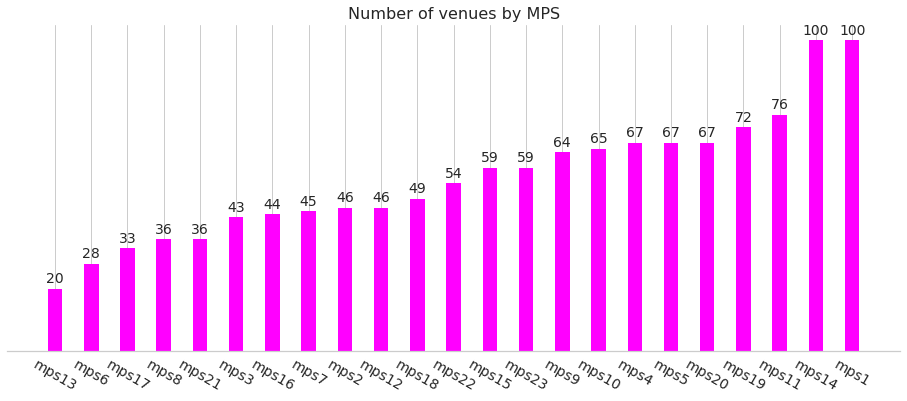

In [54]:
labels = mps_venues_count.index

venue_count = mps_venues_count['Venue']

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 6))
rects = ax.bar(x , venue_count, width, color='magenta',)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title("Number of venues by MPS",fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=-30,fontsize=14)
ax.set_yticks([])
ax.legend(fontsize=14)
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate( format(height), fontsize=14, 
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

plt.show()

#### 2.4 Data Preparation
The data still needs some more processing before it is suitable for clustering. First I have used one-hot encoding to get dummy variables.

In [55]:
# one hot encoding
mps_onehot = pd.get_dummies(mps_venues[['Venue Category']], prefix="", prefix_sep="")

# add MPS column back to dataframe
mps_onehot['MPS'] = mps_venues['MPS'] 

# move MPS column to the first column
fixed_columns = [mps_onehot.columns[-1]] + list(mps_onehot.columns[:-1])
mps_onehot = mps_onehot[fixed_columns]

mps_onehot.head()

,MPS,ATM,African Restaurant,Art Gallery,Art Museum,Asian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Tourist Information Center,Toy / Game Store,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,mps1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,mps1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,mps1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,mps1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,mps1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
mps_onehot.shape

(1276, 156)

Next I have grouped rows by MPS and calculated the mean of the frequency of occurrence of each category.

In [57]:
mps_grouped = mps_onehot.groupby('MPS').mean().reset_index()
mps_grouped.head()

,MPS,ATM,African Restaurant,Art Gallery,Art Museum,Asian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Tourist Information Center,Toy / Game Store,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,mps1,0.0,0.0,0.0,0.040000,0.010000,0.000000,0.0,0.0,0.030000,...,0.01,0.020000,0.0,0.000000,0.010000,0.010000,0.000000,0.010000,0.000000,0.000000
1,mps10,0.0,0.0,0.0,0.030769,0.000000,0.000000,0.0,0.0,0.046154,...,0.00,0.030769,0.0,0.000000,0.000000,0.015385,0.000000,0.015385,0.000000,0.000000
2,mps11,0.0,0.0,0.0,0.000000,0.013158,0.000000,0.0,0.0,0.026316,...,0.00,0.000000,0.0,0.000000,0.013158,0.013158,0.013158,0.000000,0.013158,0.013158
3,mps12,0.0,0.0,0.0,0.000000,0.000000,0.021739,0.0,0.0,0.086957,...,0.00,0.000000,0.0,0.021739,0.021739,0.000000,0.043478,0.000000,0.000000,0.000000
4,mps13,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.100000,...,0.00,0.000000,0.0,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000


In [58]:
mps_grouped.shape

(23, 156)

For further analysis I will use the top 10 venues for each MPS and put them into a new dataframe.

In [59]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [60]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['MPS']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
mps_venues_sorted = pd.DataFrame(columns=columns)
mps_venues_sorted['MPS'] = mps_grouped['MPS']

for ind in np.arange(mps_grouped.shape[0]):
    mps_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mps_grouped.iloc[ind, :], num_top_venues)

mps_venues_sorted.head()

,MPS,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,mps1,Italian Restaurant,Gift Shop,Café,Plaza,Art Museum,Clothing Store,Bakery,Hotel,Gym / Fitness Center,Pedestrian Plaza
1,mps10,Gym / Fitness Center,Italian Restaurant,Gift Shop,Bakery,Electronics Store,Café,Supermarket,Salad Place,Pedestrian Plaza,Hotel
2,mps11,Café,Italian Restaurant,French Restaurant,Ice Cream Shop,Spanish Restaurant,Pub,Plaza,Pizza Place,Bar,German Restaurant
3,mps12,Café,Bakery,Restaurant,Greek Restaurant,Vietnamese Restaurant,Supermarket,Drugstore,Pub,Thai Restaurant,Breakfast Spot
4,mps13,Hotel,Ice Cream Shop,Drugstore,Restaurant,Bakery,Bistro,Shopping Mall,German Restaurant,Bank,Plaza


### 3. Methodology
In order to identify any patterns in location of MPSes I have used KMeans algorithm. This algorithm clusters data by trying to separate samples in n groups of equal variance,  minimizing a criterion known as the inertia. Inertia is a within-cluster sum of squared distances between data cluster’s data points and its center called a centroid. KMeans algorithm requires that the number of clusters is specified. I have done this using an elbow method. This method identifies the number of clusters at which the gain in reducing distortion of the clustering result slows down.

### 4. Results


The number of clusters has been set at 6 using an elbow method.

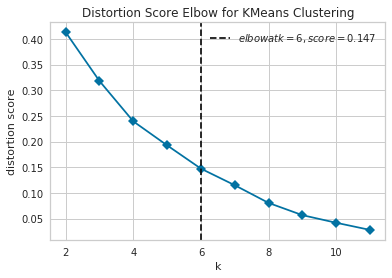

In [61]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12),timings=False, locate_elbow=True)

mps_grouped_clustering = mps_grouped.drop('MPS', 1)

visualizer.fit(mps_grouped_clustering) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure

Based on the set number of clusters I have clustered MPSes using KMeans algorithm.

In [62]:
kclusters = 6 # set number of clusters

mps_grouped_clustering = mps_grouped.drop('MPS', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mps_grouped_clustering) # k-means clustering

kmeans.labels_[0:10] # cluster labels generated for each row in the dataframe

array([1, 1, 0, 0, 4, 0, 0, 0, 3, 5], dtype=int32)

In [22]:
#kmeans.inertia_

I have created a merged dataframe with MPSes, clusters and most common venues.

In [63]:
mps_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_) # add clustering labels

mps_merged = mps_list

# merge mps_grouped with mps_data to add latitude/longitude for each MPS
mps_merged = mps_merged.join(mps_venues_sorted.set_index('MPS'), on='mps')

In [101]:
mps_merged.sort_values(by=['Cluster Labels'], ascending=True).head()

,name,categories,lat,lng,id,mps,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,o2 Partner Shop,Mobile Phone Shop,50.917056,6.923682,4c407f454a3e03bbecf56d0e,mps12,0,Café,Bakery,Restaurant,Greek Restaurant,Vietnamese Restaurant,Supermarket,Drugstore,Pub,Thai Restaurant,Breakfast Spot
15,Telekom Shop,Mobile Phone Shop,50.961319,6.954217,56cc767c498e191529e7bbc0,mps16,0,Café,Supermarket,Italian Restaurant,Bakery,Drugstore,Bookstore,Greek Restaurant,Bar,Doner Restaurant,Farmers Market
14,o2 Shop Köln 09,Mobile Phone Shop,50.962763,6.954374,5a9f01a6065ef578d47c4a2e,mps15,0,Café,Supermarket,Italian Restaurant,Bakery,Plaza,Bar,Drugstore,Restaurant,Bookstore,Thai Restaurant
13,o2 Partner Shop Köln 6,Mobile Phone Shop,50.930891,6.939958,4c407f424a3e03bbd5f56d0e,mps14,0,Café,Cocktail Bar,Italian Restaurant,Gay Bar,Bar,Nightclub,Pub,Vietnamese Restaurant,Furniture / Home Store,Restaurant
21,Vodafone Shop,Mobile Phone Shop,50.948144,6.920464,4e8ef7f5490102ea52c4d620,mps22,0,Café,Bar,Drugstore,Dive Bar,Kebab Restaurant,Ice Cream Shop,Greek Restaurant,Mini Golf,Hostel,Indian Restaurant


The map below presents markers for identified clusters

In [151]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mps_merged['lat'], mps_merged['lng'], mps_merged['mps'], mps_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In order to visualize the differences among clusters I have used data aggregated by cluster. First I have created a dataframe with MPS number and Cluster label.

In [71]:
mps_clusters = mps_merged.loc[:,['mps','Cluster Labels']]
mps_clusters.rename(columns = {'mps': 'MPS'}, inplace = True)
mps_clusters.head()

,MPS,Cluster Labels
0,mps1,1
1,mps2,5
2,mps3,0
3,mps4,1
4,mps5,1


Next I have merged this dataframe with results grouped by MPSes.

In [106]:
cluster_results = mps_clusters.merge(mps_grouped, on=('MPS'))
cluster_results.head()

,MPS,Cluster Labels,ATM,African Restaurant,Art Gallery,Art Museum,Asian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,...,Tourist Information Center,Toy / Game Store,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,mps1,1,0.0,0.0,0.0,0.040000,0.010000,0.000000,0.0,0.000000,...,0.01,0.020000,0.0,0.000000,0.010000,0.010000,0.000000,0.010000,0.0,0.0
1,mps2,5,0.0,0.0,0.0,0.000000,0.021739,0.000000,0.0,0.021739,...,0.00,0.000000,0.0,0.000000,0.043478,0.000000,0.021739,0.000000,0.0,0.0
2,mps3,0,0.0,0.0,0.0,0.000000,0.000000,0.023256,0.0,0.000000,...,0.00,0.000000,0.0,0.023256,0.000000,0.000000,0.046512,0.000000,0.0,0.0
3,mps4,1,0.0,0.0,0.0,0.044776,0.000000,0.000000,0.0,0.000000,...,0.00,0.029851,0.0,0.014925,0.000000,0.014925,0.000000,0.014925,0.0,0.0
4,mps5,1,0.0,0.0,0.0,0.044776,0.000000,0.000000,0.0,0.000000,...,0.00,0.029851,0.0,0.014925,0.000000,0.014925,0.000000,0.014925,0.0,0.0


Finally I have grouped the results for frequency of venue categories by Clusters.

In [107]:
cluster_grouped = cluster_results.groupby('Cluster Labels').mean().reset_index()
print(cluster_grouped.shape)
cluster_grouped

(6, 156)


,Cluster Labels,ATM,African Restaurant,Art Gallery,Art Museum,Asian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Tourist Information Center,Toy / Game Store,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,0,0.00496,0.004433,0.002119,0.000000,0.001645,0.005624,0.000000,0.000000,0.042192,...,0.000000,0.000000,0.000000,0.007939,0.015005,0.008197,0.016643,0.006552,0.001645,0.001645
1,1,0.00000,0.000000,0.000000,0.039468,0.001429,0.000000,0.000000,0.000000,0.036321,...,0.001429,0.028478,0.000000,0.008381,0.001429,0.014239,0.002232,0.012255,0.000000,0.000000
2,2,0.00000,0.000000,0.000000,0.000000,0.035714,0.000000,0.035714,0.000000,0.142857,...,0.000000,0.000000,0.035714,0.000000,0.178571,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.057239,...,0.000000,0.000000,0.000000,0.028620,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,...,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000
5,5,0.00000,0.000000,0.000000,0.000000,0.021457,0.000000,0.000000,0.021457,0.085826,...,0.000000,0.000000,0.000000,0.000000,0.042913,0.006803,0.021457,0.000000,0.000000,0.000000


Now I need to identyify top venue categories for Clusters. I have used the same method I have used before for MPSes.

In [108]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster Labels']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cluster_venues_sorted = pd.DataFrame(columns=columns)
cluster_venues_sorted['Cluster Labels'] = cluster_grouped['Cluster Labels']

for ind in np.arange(cluster_grouped.shape[0]):
    cluster_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cluster_grouped.iloc[ind, :], num_top_venues)

cluster_venues_sorted

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Café,Bakery,Bar,Restaurant,Italian Restaurant,Supermarket,Drugstore,Greek Restaurant,Ice Cream Shop,Thai Restaurant
1,1,Italian Restaurant,Gym / Fitness Center,Gift Shop,Art Museum,Bakery,Café,Pedestrian Plaza,Hotel,Electronics Store,Toy / Game Store
2,2,Turkish Restaurant,Bakery,Park,Café,Drugstore,Supermarket,Italian Restaurant,Ice Cream Shop,Snack Place,Burger Joint
3,3,Italian Restaurant,Café,Supermarket,Bakery,Park,Drugstore,Bus Stop,Ice Cream Shop,Fast Food Restaurant,Grocery Store
4,4,Hotel,Ice Cream Shop,Drugstore,Restaurant,Bakery,Bistro,Shopping Mall,German Restaurant,Bank,Plaza
5,5,Clothing Store,Bakery,Turkish Restaurant,Fast Food Restaurant,Pizza Place,Sporting Goods Shop,Supermarket,Drugstore,Cigkofte Place,Sandwich Place


In order to limit the number of unique venue categories I have chosen first six top categories.

In [109]:
cluster_top_categories = cluster_venues_sorted.loc[:, ['1st Most Common Venue',
                                                       '2nd Most Common Venue',
                                                       '3rd Most Common Venue',
                                                       '4th Most Common Venue',
                                                       '5th Most Common Venue',
                                                       '6th Most Common Venue']]
cluster_top_categories

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,Café,Bakery,Bar,Restaurant,Italian Restaurant,Supermarket
1,Italian Restaurant,Gym / Fitness Center,Gift Shop,Art Museum,Bakery,Café
2,Turkish Restaurant,Bakery,Park,Café,Drugstore,Supermarket
3,Italian Restaurant,Café,Supermarket,Bakery,Park,Drugstore
4,Hotel,Ice Cream Shop,Drugstore,Restaurant,Bakery,Bistro
5,Clothing Store,Bakery,Turkish Restaurant,Fast Food Restaurant,Pizza Place,Sporting Goods Shop


I have identified unique categories to be presented in the visualization.

In [110]:
np.insert(np.unique(cluster_top_categories),0, 'MPS')

array(['MPS', 'Art Museum', 'Bakery', 'Bar', 'Bistro', 'Café',
       'Clothing Store', 'Drugstore', 'Fast Food Restaurant', 'Gift Shop',
       'Gym / Fitness Center', 'Hotel', 'Ice Cream Shop',
       'Italian Restaurant', 'Park', 'Pizza Place', 'Restaurant',
       'Sporting Goods Shop', 'Supermarket', 'Turkish Restaurant'],
      dtype=object)

Finally I have created a dataframe to be vizualized.

In [111]:
cluster_top_results = cluster_grouped.loc[:,np.insert(np.unique(cluster_top_categories),0, 'Cluster Labels')]
cluster_top_results.rename(columns={'Gym / Fitness Center': 'Fitness Center'}, inplace=True)
cluster_top_results

,Cluster Labels,Art Museum,Bakery,Bar,Bistro,Café,Clothing Store,Drugstore,Fast Food Restaurant,Gift Shop,Fitness Center,Hotel,Ice Cream Shop,Italian Restaurant,Park,Pizza Place,Restaurant,Sporting Goods Shop,Supermarket,Turkish Restaurant
0,0,0.000000,0.042192,0.041824,0.007269,0.136331,0.000000,0.030035,0.000000,0.004433,0.017517,0.000000,0.026504,0.034366,0.000000,0.010618,0.036293,0.000000,0.031615,0.015005
1,1,0.039468,0.036321,0.012007,0.000000,0.033568,0.017096,0.012255,0.014239,0.043343,0.053544,0.029659,0.004841,0.056153,0.003413,0.000000,0.003661,0.015668,0.026494,0.001429
2,2,0.000000,0.142857,0.000000,0.000000,0.071429,0.000000,0.071429,0.035714,0.000000,0.000000,0.000000,0.035714,0.071429,0.071429,0.000000,0.000000,0.000000,0.071429,0.178571
3,3,0.000000,0.057239,0.000000,0.000000,0.114478,0.000000,0.057239,0.047138,0.000000,0.000000,0.000000,0.047980,0.114478,0.057239,0.000000,0.000000,0.000000,0.105219,0.000000
4,4,0.000000,0.100000,0.000000,0.050000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.100000,0.100000,0.050000,0.000000,0.000000,0.100000,0.000000,0.050000,0.050000
5,5,0.000000,0.085826,0.000000,0.006803,0.021457,0.085826,0.028259,0.042913,0.000000,0.000000,0.021457,0.021457,0.000000,0.021457,0.042913,0.000000,0.036110,0.036110,0.042913


I have decided to use polar plot as the most suitable plot for the data set with Clusters and venue categories.

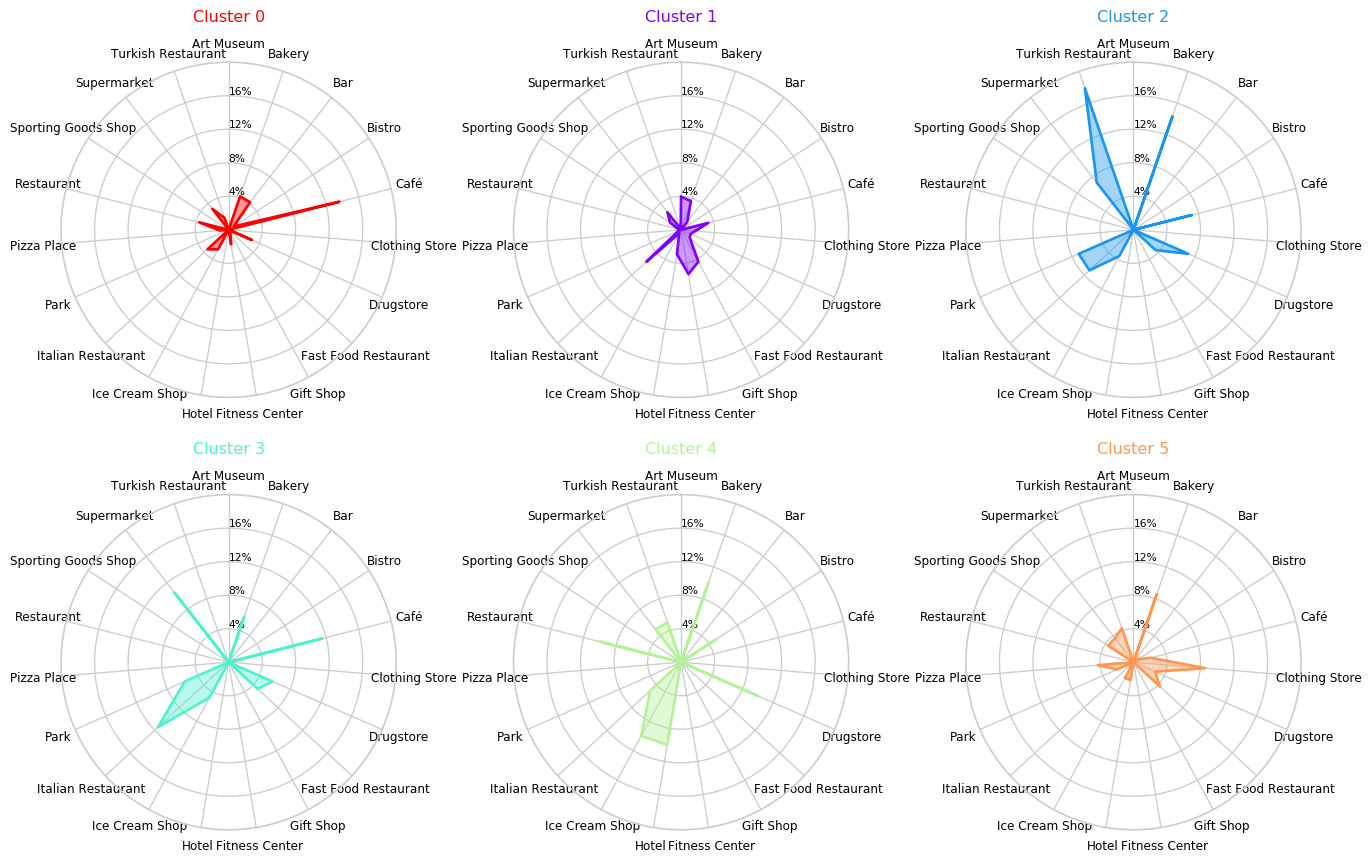

In [150]:
# Set data
data = cluster_top_results
 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider( row, title, color):
    # number of variables
    categories = list(data)[1:]
    N = len(categories)
    
    # The angle of each axis in the plot = divide the plot / number of variables
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
 
    # Initialise the spider plot
    ax = plt.subplot(2,3,row+1, polar=True,)
    
    # Adjust the layout of subplots
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=None)
 
    # The first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
 
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black', size=9)
    ax.xaxis.set_label_coords(0.1, 0.1, transform=None)
 
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.04,0.08,0.12,0.16], ["4%","8%","12%","16%"], color="black", size=8)
    plt.ylim(0,0.20)
 
    # Ind1
    values=data.loc[row].drop('Cluster Labels').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
 
    # Add a title
    plt.title(title, size=12, color=color, y=1.1)
    
    return make_spider
 
# ------- PART 2: Apply to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(1600/my_dpi, 1050/my_dpi), dpi=my_dpi)
 
# Create a color palette:
#my_palette = plt.cm.get_cmap("Set2", len(data.index))
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
 
# Loop to plot
for row in range(0,len(data.index)):
    make_spider( row=row, title='Cluster '+data['Cluster Labels'][row].astype(str), color=rainbow[row-1])

In [95]:
cluster_total = cluster_top_results
cluster_total['Total'] = cluster_total.iloc[:, 1:len(cluster_top_results.columns)-1].sum(axis=1)

In [96]:
cluster_total['Total']

0    0.418997
1    0.401731
2    0.571429
3    0.601010
4    0.650000
5    0.450587
Name: Total, dtype: float64

No handles with labels found to put in legend.


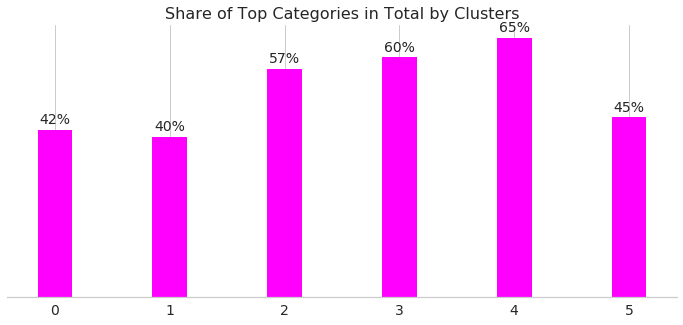

In [98]:
labels1 = cluster_total.index

top_venue_coverage = cluster_total['Total']

x1 = np.arange(len(labels1))  # the label locations
width = 0.3  # the width of the bars

fig, ax1 = plt.subplots(figsize=(12, 5))
rects1 = ax1.bar(x1 , top_venue_coverage, width, color='magenta',)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_title("Share of Top Categories in Total by Clusters",fontsize=16)
ax1.set_xticks(x1)
ax1.set_xticklabels(labels1,rotation=0,fontsize=14)
ax1.set_yticks([])
ax1.legend(fontsize=14)
ax1.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)

def autolabel(rects1):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects1:
        height = rect.get_height()
        ax1.annotate('{:.0%}'.format(height), fontsize=14, 
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)

plt.show()

In [99]:
cluster_total.loc['Category Total'] = cluster_total.sum()

In [ ]:
#cluster_total.loc['Category Total']

### 5. Discussion
Both charts show some clear patterns:
  1. some neighborhoods are more diversified (Clusters 2, 3 and 4) with more numerous venues in fewer categories and others (Clusters 0, 1 and 5) on the contrary,
  2. all Clusters include significant number of venues categorized as ‘Bakery’, ‘Supermarket’ and ‘Drugstore’,
  3. locations in the very center of the city (Cluster 1) are well diversified with significant numbers of venues categorized as ‘Art Museum’, ‘Café’, ‘Gift Shop’ and ‘Italian Restaurant’,
  4. locations around the city center (Cluster 0) are less diversified and ‘Cafes’ are dominant,
  5. other neighborhoods (Clusters 2-5) are least diversified and have a different combinations of a few dominant categories.

### 6. Conclusion
The analysis has showed some interesting patterns in locations of Points Of Sales. This is however only a first step to recommendation of a suitable place for new POSes. The following one should leverage the use of Machine Learning and help verify all potential locations based on the similarity of their neighborhoods to the ones with existing POSes.

In [448]:
@hidden cel
#mps_venues_mps_15 = mps_venues[mps_venues['MPS'] == 'mps15']
#mps_venues_mps_15.groupby('Venue Category').count()

In [114]:
categoryId_s = '52f2ab2ebcbc57f1066b8b46' # id of the category 'Supermarket'

In [115]:
latitude = 50.938361 # latitude & longitude of the center of the area for search of MPSes
longitude = 6.959974

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&categoryId={}&v={}&radius={}&limit={}'.format(
    client_id, client_secret, latitude, longitude, categoryId_s, version, radius, limit)
results_s = requests.get(url).json()
venues_s = results_s['response']['venues']
market = pd.io.json.json_normalize(venues_s)
market.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",False,5094418ce4b0f7ee4abcd951,Trankgasse 11,DE,Köln,Deutschland,Markthalle Hbf,538,"[Trankgasse 11 (Markthalle Hbf), 50667 Köln, D...","[{'label': 'display', 'lat': 50.943163, 'lng':...",50.943163,6.959008,Kunibertsviertel,50667,Nordrhein-Westfalen,REWE To Go,v-1593981007,568313349
1,"[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",False,4e3ae1c863658fc7c7a3faeb,Bremsstr. 13,DE,Köln,Deutschland,NaN,3000,"[Bremsstr. 13, 50969 Köln, Deutschland]","[{'label': 'display', 'lat': 50.91306682840577...",50.913067,6.945181,NaN,50969,Nordrhein-Westfalen,ALDI SÜD,v-1593981007,NaN
2,"[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",False,4b59e838f964a520f49f28e3,Bonner Str. 3-5,DE,Köln,Deutschland,NaN,826,"[Bonner Str. 3-5, 50677 Köln, Deutschland]","[{'label': 'display', 'lat': 50.93133676294553...",50.931337,6.956173,NaN,50677,Nordrhein-Westfalen,REWE City,v-1593981007,564362555
3,"[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",False,4e3916c8b0fb2f7ee863398f,Merheimer Str. 432,DE,Köln,Deutschland,NaN,4173,"[Merheimer Str. 432, 50739 Köln, Deutschland]","[{'label': 'display', 'lat': 50.97500097854707...",50.975001,6.947370,NaN,50739,Nordrhein-Westfalen,REWE City,v-1593981007,565363306
4,"[{'id': '52f2ab2ebcbc57f1066b8b42', 'name': 'B...",False,5bdc021b61e53b0039ec1158,Kalker Hauptstr. 112,DE,Köln,Deutschland,NaN,2925,"[Kalker Hauptstr. 112, 51103 Köln, Deutschland]","[{'label': 'display', 'lat': 50.93750539605509...",50.937505,7.001650,NaN,51103,Nordrhein-Westfalen,Kaufland,v-1593981007,518610511


In [116]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns_s = ['name', 'categories'] + [col for col in market.columns if col.startswith('location.')] + ['id']
market_filtered = market.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
market_filtered['categories'] = market_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
market_filtered.columns = [column.split('.')[-1] for column in market_filtered.columns]

market_filtered.head()

,name,categories,address,cc,city,country,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,REWE To Go,Supermarket,Trankgasse 11,DE,Köln,Deutschland,538,"[Trankgasse 11 (Markthalle Hbf), 50667 Köln, D...","[{'label': 'display', 'lat': 50.943163, 'lng':...",50.943163,6.959008,50667,Nordrhein-Westfalen,5094418ce4b0f7ee4abcd951
1,ALDI SÜD,Supermarket,Bremsstr. 13,DE,Köln,Deutschland,3000,"[Bremsstr. 13, 50969 Köln, Deutschland]","[{'label': 'display', 'lat': 50.91306682840577...",50.913067,6.945181,50969,Nordrhein-Westfalen,4e3ae1c863658fc7c7a3faeb
2,REWE City,Supermarket,Bonner Str. 3-5,DE,Köln,Deutschland,826,"[Bonner Str. 3-5, 50677 Köln, Deutschland]","[{'label': 'display', 'lat': 50.93133676294553...",50.931337,6.956173,50677,Nordrhein-Westfalen,4b59e838f964a520f49f28e3
3,REWE City,Supermarket,Merheimer Str. 432,DE,Köln,Deutschland,4173,"[Merheimer Str. 432, 50739 Köln, Deutschland]","[{'label': 'display', 'lat': 50.97500097854707...",50.975001,6.947370,50739,Nordrhein-Westfalen,4e3916c8b0fb2f7ee863398f
4,Kaufland,Big Box Store,Kalker Hauptstr. 112,DE,Köln,Deutschland,2925,"[Kalker Hauptstr. 112, 51103 Köln, Deutschland]","[{'label': 'display', 'lat': 50.93750539605509...",50.937505,7.001650,51103,Nordrhein-Westfalen,5bdc021b61e53b0039ec1158


In [117]:
market_filtered = market_filtered[market_filtered['categories'] == 'Supermarket']
market_list = market_filtered.loc[:,['name','categories','lat','lng','id']]
market_list['market']='market' + ((market_list.index+1).astype(str))
market_list.reset_index(drop = True,inplace = True)
market_list.head()

,name,categories,lat,lng,id,market
0,REWE To Go,Supermarket,50.943163,6.959008,5094418ce4b0f7ee4abcd951,market1
1,ALDI SÜD,Supermarket,50.913067,6.945181,4e3ae1c863658fc7c7a3faeb,market2
2,REWE City,Supermarket,50.931337,6.956173,4b59e838f964a520f49f28e3,market3
3,REWE City,Supermarket,50.975001,6.947370,4e3916c8b0fb2f7ee863398f,market4
4,Lidl,Supermarket,50.975369,7.057623,4fcf61103ac6d9ec99036ef8,market6


In [118]:
print(market_list.shape)

(48, 6)


In [120]:
mps_venues_market = mps_venues[mps_venues['Venue Category'] == 'Supermarket']
mps_venues_market.rename(columns={'Venue Latitude':'lat','Venue Longitude':'lng'}, inplace=True)
mps_venues_market.head()

,MPS,MPS Latitude,MPS Longitude,Venue,lat,lng,Venue Category
55,mps1,50.939075,6.956202,REWE Richrath,50.938520,6.950774,Supermarket
69,mps1,50.939075,6.956202,Galeria Gourmet,50.936585,6.955327,Supermarket
116,mps2,50.937916,6.997900,REWE,50.937738,6.996238,Supermarket
137,mps2,50.937916,6.997900,Lidl,50.934912,6.993645,Supermarket
179,mps3,50.916629,6.925656,EDEKA Romano,50.916590,6.923670,Supermarket


In [121]:
print(mps_venues_market.shape)

(45, 7)


In [122]:
market_lat_lng = market_list.loc[:, ['lat','lng']]
mps_venues_market_lat_lng = mps_venues_market.loc[:, ['lat','lng']]

In [123]:
new_centers = (market_lat_lng.merge(mps_venues_market_lat_lng, how='left', indicator='_a')
               .query('_a == "left_only"')
               .drop(['_a'], 1))
new_centers.reset_index(drop = True,inplace = True)
new_centers['center']='center' + ((new_centers.index+1).astype(str))
new_centers.head()

,lat,lng,center
0,50.943163,6.959008,center1
1,50.913067,6.945181,center2
2,50.931337,6.956173,center3
3,50.975001,6.947370,center4
4,50.975369,7.057623,center5


In [96]:
print(new_centers.shape)

(40, 3)


In [124]:
map_new_centers = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, label in zip(new_centers['lat'], new_centers['lng'], new_centers['center']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#696969',
        fill=True,
        fill_color='#c3c3c3',
        fill_opacity=0.7,
        parse_html=False).add_to(map_new_centers)

for lat, lng, label in zip(mps_list['lat'], mps_list['lng'], mps_list['mps']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='magenta',
        fill=True,
        fill_color='#ff7fff',
        fill_opacity=0.7,
        parse_html=False).add_to(map_new_centers)
    
map_new_centers

In [125]:
def getNearbyVenues_c(names, latitudes, longitudes, radius=radius_v):

    venues_list_c=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            client_id, 
            client_secret, 
            version, 
            lat, 
            lng, 
            radius_v, 
            limit)

        # make the GET request
        results_c = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list_c.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results_c])

    nearby_venues_c = pd.DataFrame([item for venue_list_c in venues_list_c for item in venue_list_c])
    nearby_venues_c.columns = ['Center',
                             'Center Latitude',
                             'Center Longitude',
                             'Venue',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Venue Category']

    return(nearby_venues_c)

In [126]:
center_venues = getNearbyVenues_c(names = new_centers['center'],
                             latitudes = new_centers['lat'],
                             longitudes = new_centers['lng'])

center1
center2
center3
center4
center5
center6
center7
center8
center9
center10
center11
center12
center13
center14
center15
center16
center17
center18
center19
center20
center21
center22
center23
center24
center25
center26
center27
center28
center29
center30
center31
center32
center33
center34
center35
center36
center37
center38
center39
center40


In [127]:
print(center_venues.shape)
center_venues.head()

(1085, 7)


,Center,Center Latitude,Center Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,center1,50.943163,6.959008,Haferkater,50.943132,6.958586,Coffee Shop
1,center1,50.943163,6.959008,Excelsior Hotel Ernst,50.942222,6.956282,Hotel
2,center1,50.943163,6.959008,Museum Ludwig,50.940826,6.959863,Art Museum
3,center1,50.943163,6.959008,Wartesaal am Dom,50.941951,6.958845,Modern European Restaurant
4,center1,50.943163,6.959008,Enoteca La Cantina,50.944522,6.955899,Gourmet Shop


In [128]:
filter_list = np.unique(mps_venues['Venue Category'])

In [129]:
center_venues_filtered = center_venues[center_venues['Venue Category'].isin(filter_list)]

In [130]:
center_venues_filtered.groupby('Center').count().sort_values(by=['Venue'], ascending=True)

,Center Latitude,Center Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Center,,,,,,
center13,1,1,1,1,1,1
center30,1,1,1,1,1,1
center5,3,3,3,3,3,3
center17,3,3,3,3,3,3
center35,3,3,3,3,3,3
center14,4,4,4,4,4,4
center15,4,4,4,4,4,4
center9,5,5,5,5,5,5
center12,5,5,5,5,5,5


In [131]:
# one hot encoding
center_onehot = pd.get_dummies(center_venues_filtered[['Venue Category']], prefix="", prefix_sep="")

# add MPS column back to dataframe
center_onehot['Center'] = center_venues_filtered['Center'] 

# move MPS column to the first column
fixed_columns = [center_onehot.columns[-1]] + list(center_onehot.columns[:-1])
center_onehot = center_onehot[fixed_columns]

center_onehot.head()

,Center,ATM,African Restaurant,Art Gallery,Art Museum,Asian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Tourist Information Center,Toy / Game Store,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,center1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,center1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,center1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,center1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,center1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [132]:
center_onehot.shape

(963, 133)

In [133]:
center_grouped = center_onehot.groupby('Center').mean().reset_index()
center_grouped.head()

,Center,ATM,African Restaurant,Art Gallery,Art Museum,Asian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Tourist Information Center,Toy / Game Store,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,center1,0.011364,0.000000,0.000000,0.022727,0.022727,0.0,0.0,0.0,0.079545,...,0.011364,0.0,0.0,0.0,0.011364,0.000000,0.0,0.000000,0.0,0.0
1,center10,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
2,center11,0.000000,0.016949,0.016949,0.000000,0.000000,0.0,0.0,0.0,0.016949,...,0.000000,0.0,0.0,0.0,0.000000,0.016949,0.0,0.016949,0.0,0.0
3,center12,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.200000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
4,center13,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0


In [134]:
center_grouped_clustering = center_grouped.drop('Center', 1)

In [135]:
center_grouped_clustering.head()

,ATM,African Restaurant,Art Gallery,Art Museum,Asian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,...,Tourist Information Center,Toy / Game Store,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,0.011364,0.000000,0.000000,0.022727,0.022727,0.0,0.0,0.0,0.079545,0.011364,...,0.011364,0.0,0.0,0.0,0.011364,0.000000,0.0,0.000000,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
2,0.000000,0.016949,0.016949,0.000000,0.000000,0.0,0.0,0.0,0.016949,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.016949,0.0,0.016949,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.200000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0


In [136]:
from sklearn.neighbors import KNeighborsClassifier
kNN_model = KNeighborsClassifier(n_neighbors=kclusters).fit(mps_grouped_clustering,kmeans.labels_)
kNN_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='uniform')

In [137]:
mps_grouped_clustering.head()

,ATM,African Restaurant,Art Gallery,Art Museum,Asian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,...,Tourist Information Center,Toy / Game Store,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,0.0,0.0,0.0,0.040000,0.010000,0.000000,0.0,0.0,0.030000,0.00,...,0.01,0.020000,0.0,0.000000,0.010000,0.010000,0.000000,0.010000,0.000000,0.000000
1,0.0,0.0,0.0,0.030769,0.000000,0.000000,0.0,0.0,0.046154,0.00,...,0.00,0.030769,0.0,0.000000,0.000000,0.015385,0.000000,0.015385,0.000000,0.000000
2,0.0,0.0,0.0,0.000000,0.013158,0.000000,0.0,0.0,0.026316,0.00,...,0.00,0.000000,0.0,0.000000,0.013158,0.013158,0.013158,0.000000,0.013158,0.013158
3,0.0,0.0,0.0,0.000000,0.000000,0.021739,0.0,0.0,0.086957,0.00,...,0.00,0.000000,0.0,0.021739,0.021739,0.000000,0.043478,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.100000,0.05,...,0.00,0.000000,0.0,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000


In [138]:
#predictions = kNN_model.predict(center_grouped_clustering)
#predictions